In [25]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from os import listdir
from os.path import isfile, join
from google.colab import drive
drive.mount('/content/drive')
from random import randint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# fichiers = [f for f in listdir('/content/drive/MyDrive/Ljubljana Internship/Female Faces') if isfile(join('/content/drive/MyDrive/Ljubljana Internship/Female Faces', f))]
makeup = [f for f in listdir('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/makeup') if isfile(join('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/makeup', f))]
# faces = [f for f in listdir('/content/Shape Predictor') if isfile(join('/content/Shape Predictor', f))]
# print(len(fichiers))
print(len(makeup))
randint(0,8)

10


8

In [27]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor("/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/shape_predictor_68_face_landmarks.dat")

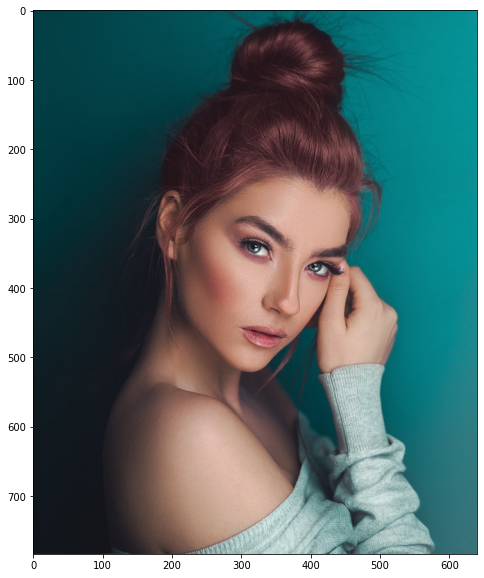

In [28]:
  image = dlib.load_rgb_image('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/01.jpg')
  plt.figure(figsize=(16, 10))
  plt.imshow(image)
  plt.show()

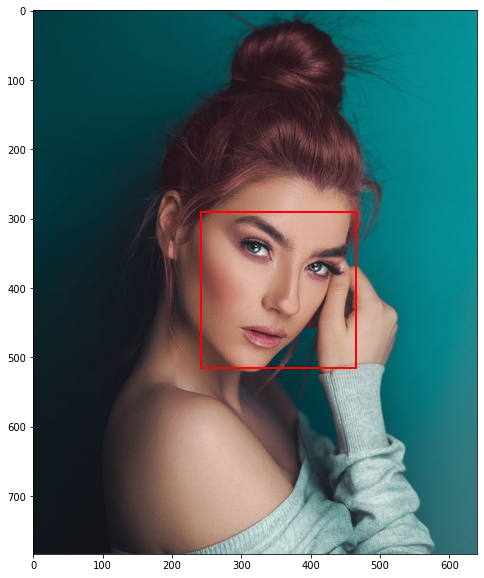

<Figure size 432x288 with 0 Axes>

In [29]:
    img=dlib.load_rgb_image('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/01.jpg')
    img_result = img.copy()
    dets = detector(img, 1)
  
    if len(dets) == 0:
      print('cannot find faces for '+ image)

    fig, ax = plt.subplots(1, figsize=(16, 10))

    for det in dets:  
      x, y, w, h = det.left(), det.top(), det.width(), det.height()

    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.imshow(img_result)
    plt.show()

    plt.clf()

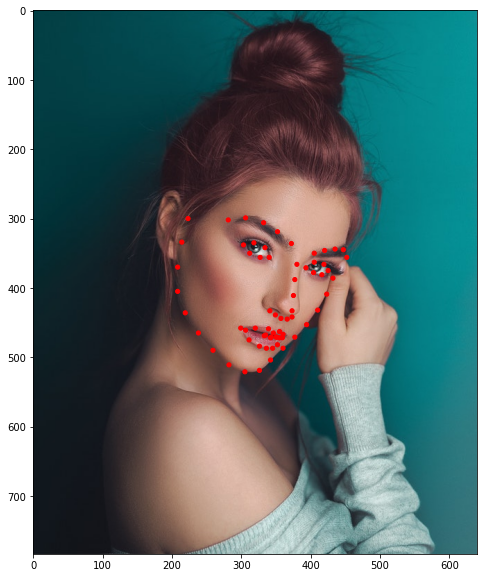

In [30]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection)
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

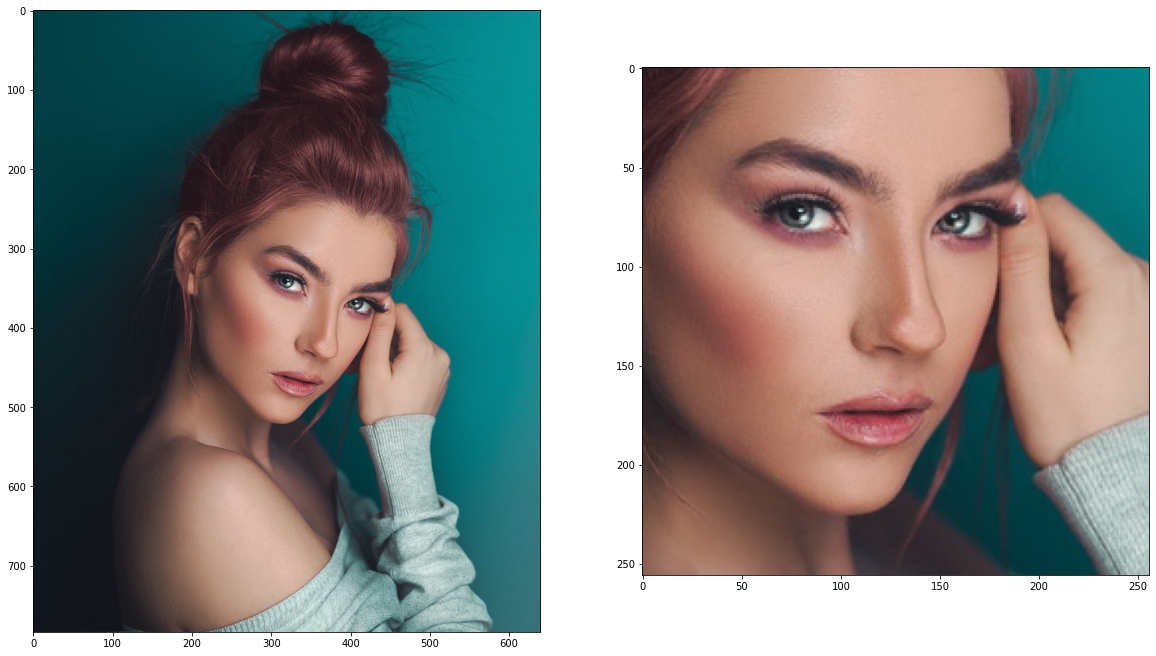

In [31]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3)

fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))

axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

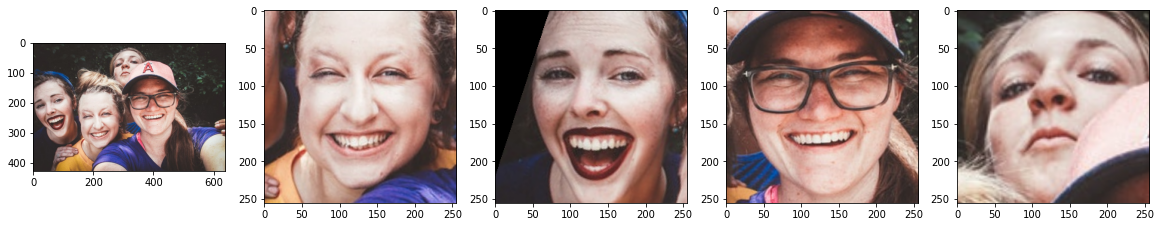

In [32]:
def align_faces(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()

    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces

# test
test_img = dlib.load_rgb_image('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/02.jpg')

test_faces = align_faces(test_img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

In [33]:
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/'))
graph = tf.compat.v1.get_default_graph()

X = graph.get_tensor_by_name('X:0')
Y = graph.get_tensor_by_name('Y:0')
Xs = graph.get_tensor_by_name('generator/xs:0')

In [34]:
def preprocess(img):
  return (img.astype(np.float32)/127.5 - 1.)

def postprocess(img):
  return (((img + 1.) * 127.5)).astype(np.uint8)

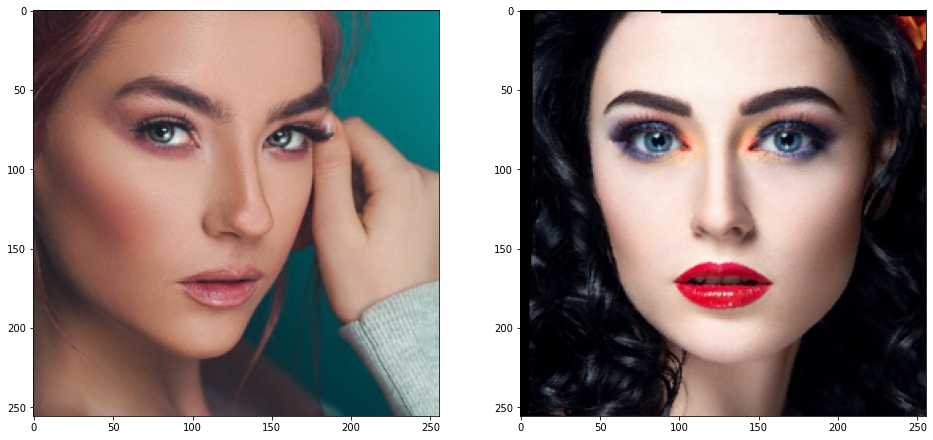

In [35]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/01.jpg')
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/Ljubljana Internship/BeautyGAN/makeup/XMY-014.png')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1,2,figsize=(16,10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

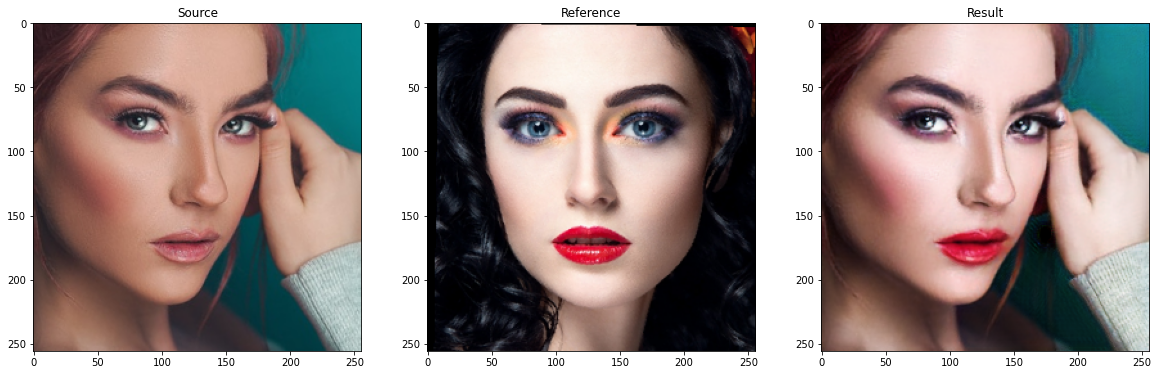

In [36]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs,feed_dict={X: X_img, Y:Y_img})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1,3,figsize=(20,10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)